# Deep Learning - Programming Assignment 1

    Ayush Abrol B20AI052

---

## Question 1 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torchvision
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import PIL
from torchvision.utils import save_image
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# Loading the CIFAR-10 dataset
train_loader = torch.utils.data.DataLoader(  
    datasets.CIFAR10('data', train=True, download=True,
                        transform=train_transform),
    batch_size=128, shuffle=True) # 128 is the batch size

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=test_transform),
    batch_size=128, shuffle=False)  

Files already downloaded and verified


In [5]:
X_train = train_loader.dataset.data # 50000 images
y_train = np.array(train_loader.dataset.targets) # 50000 labels
X_test = test_loader.dataset.data # 10000 images
y_test = np.array(test_loader.dataset.targets) # 10000 labels

print("Train data shape: ", X_train.shape) 
print("Test data shape: ", X_test.shape)

print("Train data labels shape: ", y_train.shape)
print("Test data labels shape: ", y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)
Train data labels shape:  (50000,)
Test data labels shape:  (10000,)


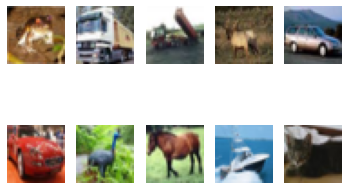

In [6]:
# Visualizing the images in RGB format
for i in range(10): 
    plt.subplot(2,5,i+1) 
    plt.imshow(X_train[i]) # Displaying the image
    plt.axis('off')

In [7]:
def create_dataloader(x_train, y_train, x_test, y_test):
    x_train, x_test, y_train, y_test = torch.Tensor(x_train).permute(0, 3, 1, 2), torch.Tensor(x_test).permute(0, 3, 1, 2), torch.Tensor(y_train), torch.Tensor(y_test)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle = True)

    testset = torch.utils.data.TensorDataset(x_test, y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle = False)

    return trainloader, testloader

trainloader, testloader = create_dataloader(X_train, y_train, X_test, y_test)

torch.Size([50000, 3, 32, 32]) torch.Size([50000]) torch.Size([10000, 3, 32, 32]) torch.Size([10000])


In [8]:
classes = ['plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # List of classes

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

In [29]:
class CNN(nn.Module):
    def __init__(self, activation_function, num_fc_layers, fc_layer_list, output_classes):
        super(CNN, self).__init__()
        self.activation_function = activation_function
        self.num_fc_layers = num_fc_layers
        self.fc_layer_size = fc_layer_list
        self.output_classes = output_classes
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc_block = nn.Sequential()
        for i in range(self.num_fc_layers):
            if i == 0:
                self.fc_block.add_module("fc"+str(i), nn.Linear(4*4*128, self.fc_layer_size[i]))
                self.fc_block.add_module("activation"+str(i), self.activation_function)
            else:
                self.fc_block.add_module("fc"+str(i), nn.Linear(self.fc_layer_size[i-1], self.fc_layer_size[i]))
                self.fc_block.add_module("activation"+str(i), self.activation_function)
        self.fc_block.add_module("fc"+str(self.num_fc_layers), nn.Linear(self.fc_layer_size[self.num_fc_layers-1], self.output_classes))
        nn.Softmax(dim=1)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.activation_function(x)
        x = self.pool(x)
        x = x.view(-1, 4*4*128)
        x = self.dropout(x)
        x = self.fc_block(x)
        return x

In [30]:
model_relu = CNN(nn.ReLU(), 3, [512, 256, 128], 10).to(device)
model_relu

CNN(
  (activation_function): ReLU()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_block): Sequential(
    (fc0): Linear(in_features=2048, out_features=512, bias=True)
    (activation0): ReLU()
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (activation1): ReLU()
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (activation2): ReLU()
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [31]:
model_sigmod = CNN(nn.Sigmoid(), 3, [512, 256, 128], 10).to(device)
model_sigmod

CNN(
  (activation_function): Sigmoid()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_block): Sequential(
    (fc0): Linear(in_features=2048, out_features=512, bias=True)
    (activation0): Sigmoid()
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (activation1): Sigmoid()
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (activation2): Sigmoid()
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [32]:
model_tanh = CNN(nn.Tanh(), 3, [512, 256, 128], 10).to(device)
model_tanh

CNN(
  (activation_function): Tanh()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_block): Sequential(
    (fc0): Linear(in_features=2048, out_features=512, bias=True)
    (activation0): Tanh()
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (activation1): Tanh()
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (activation2): Tanh()
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Utilizing various activation functions like ReLU, sigmoid, tanh and critiquing the performance in each case with 3 fully connected layers.

In [33]:
model_list = [model_relu, model_sigmod, model_tanh]
loss_fn = nn.CrossEntropyLoss() # Loss function
optimizer_list = [torch.optim.Adam(model.parameters(), lr=0.001) for model in model_list] # Optimizers for each activation function

In [34]:
def train_model(model, optimizer, epochs, train_loss, train_accuracy):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(inputs)
            print(outputs.shape, labels.shape)
            loss = loss_fn(outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss/len(trainloader)
        avg_accuracy = correct/len(trainloader.dataset)
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        print("Epoch:", epoch+1, "Training Loss: ", avg_loss, "\t Training Accuracy: ", avg_accuracy)
    return train_loss, train_accuracy

In [35]:
# Training for ReLU activation function
train_loss_relu = []
train_accuracy_relu = []
train_loss_relu, train_accuracy_relu =  train_model(model = model_list[0], optimizer = optimizer_list[0], epochs = 25, train_loss = train_loss_relu, train_accuracy = train_accuracy_relu)
print("Training Complete for ReLU.")

Epoch: 1 Training Loss:  1.6236510660947132 	 Training Accuracy:  0.411
Epoch: 2 Training Loss:  1.1937389360059558 	 Training Accuracy:  0.57392
Epoch: 3 Training Loss:  1.0218395127359863 	 Training Accuracy:  0.63988
Epoch: 4 Training Loss:  0.9081671876675638 	 Training Accuracy:  0.68324
Epoch: 5 Training Loss:  0.8176651607693919 	 Training Accuracy:  0.71366
Epoch: 6 Training Loss:  0.7395366791569059 	 Training Accuracy:  0.74042
Epoch: 7 Training Loss:  0.6856849714923088 	 Training Accuracy:  0.757
Epoch: 8 Training Loss:  0.6366907646284079 	 Training Accuracy:  0.77794
Epoch: 9 Training Loss:  0.5917634665203826 	 Training Accuracy:  0.79242
Epoch: 10 Training Loss:  0.5566132548824906 	 Training Accuracy:  0.8053
Epoch: 11 Training Loss:  0.514335576759275 	 Training Accuracy:  0.81886
Epoch: 12 Training Loss:  0.485999045088468 	 Training Accuracy:  0.82708
Epoch: 13 Training Loss:  0.4555739914745931 	 Training Accuracy:  0.83952
Epoch: 14 Training Loss:  0.4268874868255

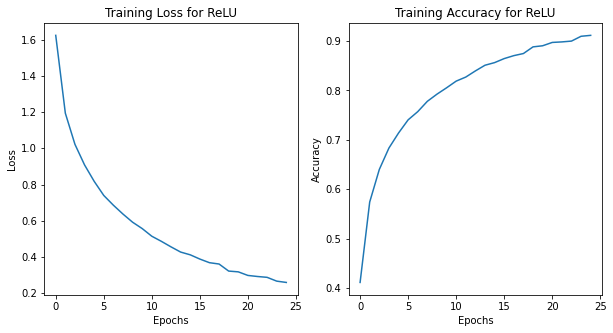

In [36]:
# Plotting the training loss and accuracy for ReLU
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_relu)
plt.title("Training Loss for ReLU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_relu)
plt.title("Training Accuracy for ReLU")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [37]:
# Testing for ReLU 
test_loss = []
test_accuracy = []
model_list[0].eval()
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_list[0](inputs)
        loss = loss_fn(outputs, labels.long())
        test_loss.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        test_accuracy.append(correct/len(labels))

print("Testing Complete for ReLU.")
print("Test Loss: ", np.mean(test_loss), "\t Test Accuracy: ", np.mean(test_accuracy))

Testing Complete for ReLU.
Test Loss:  0.8145717148539386 	 Test Accuracy:  0.753065664556962


In [38]:
# Training for Sigmoid activation function
train_loss_sigmod = []
train_accuracy_sigmod = []
train_loss_sigmod, train_accuracy_sigmod =  train_model(model = model_list[1], optimizer = optimizer_list[1], epochs = 25, train_loss = train_loss_sigmod, train_accuracy = train_accuracy_sigmod)
print("Training Complete for Sigmoid.")

Epoch: 1 Training Loss:  2.045787964940376 	 Training Accuracy:  0.21212
Epoch: 2 Training Loss:  1.6525021504868023 	 Training Accuracy:  0.3831
Epoch: 3 Training Loss:  1.4769081291945085 	 Training Accuracy:  0.45494
Epoch: 4 Training Loss:  1.3387881124111087 	 Training Accuracy:  0.51312
Epoch: 5 Training Loss:  1.2182957565083223 	 Training Accuracy:  0.5597
Epoch: 6 Training Loss:  1.1163231113072856 	 Training Accuracy:  0.60014
Epoch: 7 Training Loss:  1.028813648406807 	 Training Accuracy:  0.63198
Epoch: 8 Training Loss:  0.9561578381396926 	 Training Accuracy:  0.66084
Epoch: 9 Training Loss:  0.8918368159352666 	 Training Accuracy:  0.68338
Epoch: 10 Training Loss:  0.8339247101408136 	 Training Accuracy:  0.705
Epoch: 11 Training Loss:  0.7862719038258428 	 Training Accuracy:  0.72194
Epoch: 12 Training Loss:  0.7294558499322827 	 Training Accuracy:  0.74268
Epoch: 13 Training Loss:  0.6851239825606041 	 Training Accuracy:  0.75994
Epoch: 14 Training Loss:  0.632452026504

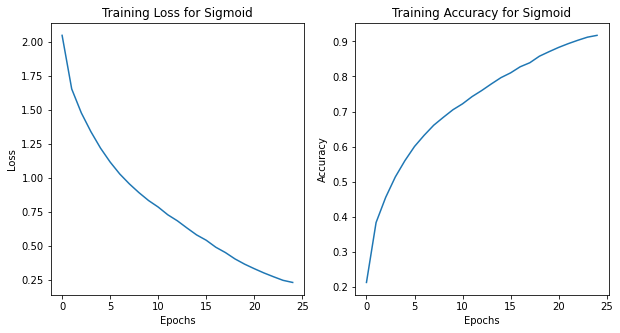

In [39]:
# Plotting the training loss and accuracy for Sigmoid
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_sigmod)
plt.title("Training Loss for Sigmoid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_sigmod)
plt.title("Training Accuracy for Sigmoid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [40]:
# Testing for Sigmoid
test_loss = []
test_accuracy = []
model_list[1].eval()
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_list[1](inputs)
        loss = loss_fn(outputs, labels.long())
        test_loss.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        test_accuracy.append(correct/len(labels))

print("Testing Complete for Sigmoid.")
print("Test Loss: ", np.mean(test_loss), "\t Test Accuracy: ", np.mean(test_accuracy))

Testing Complete for Sigmoid.
Test Loss:  0.9361641456054736 	 Test Accuracy:  0.7316060126582279


In [41]:
# Training for Tanh activation function
train_loss_tanh = []
train_accuracy_tanh = []
train_loss_tanh, train_accuracy_tanh =  train_model(model = model_list[2], optimizer = optimizer_list[2], epochs = 25, train_loss = train_loss_tanh, train_accuracy = train_accuracy_tanh)
print("Training Complete for Tanh.")

Epoch: 1 Training Loss:  1.5140601515465075 	 Training Accuracy:  0.44674
Epoch: 2 Training Loss:  1.1776210661129574 	 Training Accuracy:  0.58044
Epoch: 3 Training Loss:  1.0397359065692444 	 Training Accuracy:  0.62968
Epoch: 4 Training Loss:  0.9558008587573801 	 Training Accuracy:  0.66356
Epoch: 5 Training Loss:  0.8952507080934237 	 Training Accuracy:  0.68416
Epoch: 6 Training Loss:  0.8412559771781687 	 Training Accuracy:  0.70448
Epoch: 7 Training Loss:  0.8138410604518392 	 Training Accuracy:  0.71406
Epoch: 8 Training Loss:  0.7880501292855538 	 Training Accuracy:  0.72322
Epoch: 9 Training Loss:  0.7569173435725824 	 Training Accuracy:  0.73206
Epoch: 10 Training Loss:  0.7323352866770362 	 Training Accuracy:  0.73948
Epoch: 11 Training Loss:  0.7249128147769157 	 Training Accuracy:  0.74526
Epoch: 12 Training Loss:  0.6959306468896549 	 Training Accuracy:  0.7536
Epoch: 13 Training Loss:  0.6955383115869653 	 Training Accuracy:  0.75624
Epoch: 14 Training Loss:  0.6774650

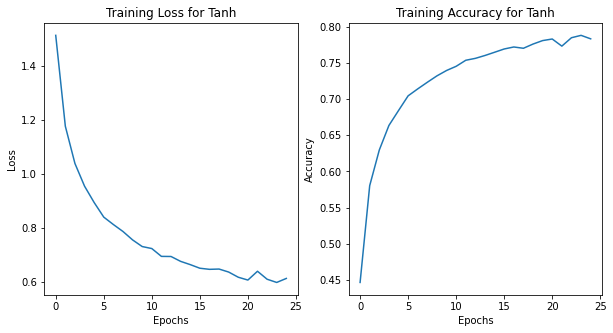

In [42]:
# Plotting the training loss and accuracy for Tanh
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_tanh)
plt.title("Training Loss for Tanh")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_tanh)
plt.title("Training Accuracy for Tanh")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [43]:
# Testing for Tanh
test_loss = []
test_accuracy = []
model_list[2].eval()
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_list[2](inputs)
        loss = loss_fn(outputs, labels.long())
        test_loss.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        test_accuracy.append(correct/len(labels))

print("Testing Complete for Tanh.")
print("Test Loss: ", np.mean(test_loss), "\t Test Accuracy: ", np.mean(test_accuracy))

Testing Complete for Tanh.
Test Loss:  1.4167923338805573 	 Test Accuracy:  0.5666534810126582


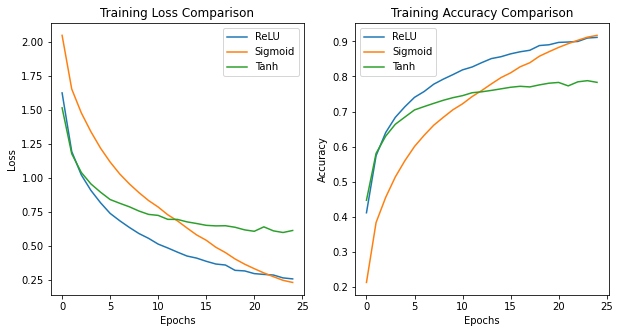

In [44]:
# Comparison between the losses and accuracies of the three activation functions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_relu, label = "ReLU")
plt.plot(train_loss_sigmod, label = "Sigmoid")
plt.plot(train_loss_tanh, label = "Tanh")
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_relu, label = "ReLU")
plt.plot(train_accuracy_sigmod, label = "Sigmoid")
plt.plot(train_accuracy_tanh, label = "Tanh")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Increasing the depth of the given network(Sigmoid or tanh) by adding more Fully-Connected layers till the point we encounter the vanishing gradient problem.

Note: We can't use ReLU here as it won't lead to vanishing gradient problem because it is a non-saturating function which means that it doesn't saturate to 0 or 1.

#### Finding number of layers where the vanishing gradient problem occurs for the Sigmod activation function.

In [45]:
# Increasing the number of hidden layers for Sigmoid activation function
model_list_fc_layers = []
model_list_fc_layers.append(CNN(nn.Sigmoid(), 4, [512, 256, 128, 64], 10).to(device))
model_list_fc_layers.append(CNN(nn.Sigmoid(), 5, [512, 256, 128, 64, 32], 10).to(device))
model_list_fc_layers.append(CNN(nn.Sigmoid(), 6, [512, 256, 128, 64, 32, 16], 10).to(device))
model_list_fc_layers.append(CNN(nn.Sigmoid(), 7, [512, 384, 256, 128, 64, 32, 16], 10).to(device))

In [46]:
optimizer_list_fc_layers = []
optimizer_list_fc_layers.append(torch.optim.Adam(model_list_fc_layers[0].parameters(), lr = 0.001))
optimizer_list_fc_layers.append(torch.optim.Adam(model_list_fc_layers[1].parameters(), lr = 0.001))
optimizer_list_fc_layers.append(torch.optim.Adam(model_list_fc_layers[2].parameters(), lr = 0.001))
optimizer_list_fc_layers.append(torch.optim.Adam(model_list_fc_layers[3].parameters(), lr = 0.001))

In [47]:
# Training for 4 hidden layers
train_loss_4 = []
train_accuracy_4 = []
train_loss_4, train_accuracy_4 =  train_model(model = model_list_fc_layers[0], optimizer = optimizer_list_fc_layers[0], epochs = 25, train_loss = train_loss_4, train_accuracy = train_accuracy_4)
print("Training Complete for 4 hidden layers.")

Epoch: 1 Training Loss:  2.1169569647830464 	 Training Accuracy:  0.18236
Epoch: 2 Training Loss:  1.8326037268504463 	 Training Accuracy:  0.28098
Epoch: 3 Training Loss:  1.641488320992121 	 Training Accuracy:  0.37004
Epoch: 4 Training Loss:  1.5458306714396952 	 Training Accuracy:  0.42632
Epoch: 5 Training Loss:  1.4559560553801945 	 Training Accuracy:  0.46968
Epoch: 6 Training Loss:  1.3467449437626793 	 Training Accuracy:  0.51348
Epoch: 7 Training Loss:  1.2345596974158226 	 Training Accuracy:  0.5575
Epoch: 8 Training Loss:  1.1421831593184215 	 Training Accuracy:  0.59046
Epoch: 9 Training Loss:  1.063811593348413 	 Training Accuracy:  0.61846
Epoch: 10 Training Loss:  0.994308767111405 	 Training Accuracy:  0.64726
Epoch: 11 Training Loss:  0.9310373336152957 	 Training Accuracy:  0.67092
Epoch: 12 Training Loss:  0.8742898794086388 	 Training Accuracy:  0.69192
Epoch: 13 Training Loss:  0.8242866563065278 	 Training Accuracy:  0.70918
Epoch: 14 Training Loss:  0.7744439052

In [48]:
train_loss_5 = []
train_accuracy_5 = []
train_loss_5, train_accuracy_5 =  train_model(model = model_list_fc_layers[1], optimizer = optimizer_list_fc_layers[1], epochs = 25, train_loss = train_loss_5, train_accuracy = train_accuracy_5)
print("Training Complete for 5 hidden layers.")

Epoch: 1 Training Loss:  2.3043649690535366 	 Training Accuracy:  0.10122
Epoch: 2 Training Loss:  2.303729459757695 	 Training Accuracy:  0.10074
Epoch: 3 Training Loss:  2.303555919081354 	 Training Accuracy:  0.0982
Epoch: 4 Training Loss:  2.303568110746496 	 Training Accuracy:  0.09992
Epoch: 5 Training Loss:  2.3034939503730714 	 Training Accuracy:  0.10108
Epoch: 6 Training Loss:  2.303350444340035 	 Training Accuracy:  0.10014
Epoch: 7 Training Loss:  2.303247133484277 	 Training Accuracy:  0.10016
Epoch: 8 Training Loss:  2.3033337276000196 	 Training Accuracy:  0.0992
Epoch: 9 Training Loss:  2.303142841514724 	 Training Accuracy:  0.10022
Epoch: 10 Training Loss:  2.302939088143351 	 Training Accuracy:  0.10116
Epoch: 11 Training Loss:  2.3030983602909174 	 Training Accuracy:  0.09752
Epoch: 12 Training Loss:  2.3029600378802364 	 Training Accuracy:  0.0997
Epoch: 13 Training Loss:  2.302898759427278 	 Training Accuracy:  0.10074
Epoch: 14 Training Loss:  2.3028430298466205 

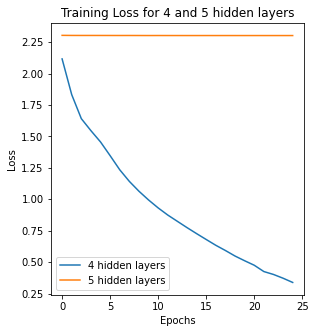

In [49]:
# Plotting the training loss for 4 and 5 hidden layers
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_4, label = "4 hidden layers")
plt.plot(train_loss_5, label = "5 hidden layers")
plt.title("Training Loss for 4 and 5 hidden layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Therefore, at 5 fully connected layers, we will encounter the vanishing gradient problem in case of sigmoid activation function.

#### Finding number of layers where the vanishing gradient problem occurs for the tanh activation function.

In [50]:
model_list_fc_layers_tanh = []
model_list_fc_layers_tanh.append(CNN(nn.Tanh(), 4, [512, 256, 128, 64], 10).to(device))
model_list_fc_layers_tanh.append(CNN(nn.Tanh(), 5, [512, 256, 128, 64, 32], 10).to(device))
model_list_fc_layers_tanh.append(CNN(nn.Tanh(), 6, [512, 256, 128, 64, 32, 16], 10).to(device))
model_list_fc_layers_tanh.append(CNN(nn.Tanh(), 7, [512, 384, 256, 128, 64, 32, 16], 10).to(device))

In [51]:
optimizer_list_fc_layers_tanh = []
optimizer_list_fc_layers_tanh.append(torch.optim.Adam(model_list_fc_layers_tanh[0].parameters(), lr = 0.001))
optimizer_list_fc_layers_tanh.append(torch.optim.Adam(model_list_fc_layers_tanh[1].parameters(), lr = 0.001))
optimizer_list_fc_layers_tanh.append(torch.optim.Adam(model_list_fc_layers_tanh[2].parameters(), lr = 0.001))
optimizer_list_fc_layers_tanh.append(torch.optim.Adam(model_list_fc_layers_tanh[3].parameters(), lr = 0.001))

In [52]:
# Training for 4 hidden layers
train_loss_4_tanh = []
train_accuracy_4_tanh = []
train_loss_4_tanh, train_accuracy_4_tanh =  train_model(model = model_list_fc_layers_tanh[0], optimizer = optimizer_list_fc_layers_tanh[0], epochs = 25, train_loss = train_loss_4_tanh, train_accuracy = train_accuracy_4_tanh)
print("Training Complete for 4 hidden layers.")

Epoch: 1 Training Loss:  1.5783059965923925 	 Training Accuracy:  0.419
Epoch: 2 Training Loss:  1.256828655062429 	 Training Accuracy:  0.54774
Epoch: 3 Training Loss:  1.130258050721015 	 Training Accuracy:  0.59672
Epoch: 4 Training Loss:  1.0345132171040605 	 Training Accuracy:  0.632
Epoch: 5 Training Loss:  0.9580667939637323 	 Training Accuracy:  0.66206
Epoch: 6 Training Loss:  0.9268227565623915 	 Training Accuracy:  0.67306
Epoch: 7 Training Loss:  0.8815794369143903 	 Training Accuracy:  0.69016
Epoch: 8 Training Loss:  0.8575145605275089 	 Training Accuracy:  0.69726
Epoch: 9 Training Loss:  0.8301914061426812 	 Training Accuracy:  0.70846
Epoch: 10 Training Loss:  0.8040131348783098 	 Training Accuracy:  0.71742
Epoch: 11 Training Loss:  0.7851098002985005 	 Training Accuracy:  0.72356
Epoch: 12 Training Loss:  0.7617620312039505 	 Training Accuracy:  0.7308
Epoch: 13 Training Loss:  0.7553362503381031 	 Training Accuracy:  0.7324
Epoch: 14 Training Loss:  0.73832483982186

In [53]:
# Training for 5 hidden layers
train_loss_5_tanh = []
train_accuracy_5_tanh = []
train_loss_5_tanh, train_accuracy_5_tanh =  train_model(model = model_list_fc_layers_tanh[1], optimizer = optimizer_list_fc_layers_tanh[1], epochs = 25, train_loss = train_loss_5_tanh, train_accuracy = train_accuracy_5_tanh)
print("Training Complete for 5 hidden layers.")

Epoch: 1 Training Loss:  1.6683652236333588 	 Training Accuracy:  0.37976
Epoch: 2 Training Loss:  1.356659183721713 	 Training Accuracy:  0.51008
Epoch: 3 Training Loss:  1.2070551604566062 	 Training Accuracy:  0.5662
Epoch: 4 Training Loss:  1.1122872442235727 	 Training Accuracy:  0.60126
Epoch: 5 Training Loss:  1.0593703611732443 	 Training Accuracy:  0.62444
Epoch: 6 Training Loss:  1.0035022216684677 	 Training Accuracy:  0.64496
Epoch: 7 Training Loss:  0.9467895617875297 	 Training Accuracy:  0.6683
Epoch: 8 Training Loss:  0.9151536157673887 	 Training Accuracy:  0.67754
Epoch: 9 Training Loss:  0.8933282614973805 	 Training Accuracy:  0.68524
Epoch: 10 Training Loss:  0.880298899415204 	 Training Accuracy:  0.6911
Epoch: 11 Training Loss:  0.8563077815658297 	 Training Accuracy:  0.69858
Epoch: 12 Training Loss:  0.8289064844246106 	 Training Accuracy:  0.71064
Epoch: 13 Training Loss:  0.8067187047980325 	 Training Accuracy:  0.71728
Epoch: 14 Training Loss:  0.79910849838

In [54]:
# Training for 6 hidden layers
train_loss_6_tanh = []
train_accuracy_6_tanh = []
train_loss_6_tanh, train_accuracy_6_tanh =  train_model(model = model_list_fc_layers_tanh[2], optimizer = optimizer_list_fc_layers_tanh[2], epochs = 25, train_loss = train_loss_6_tanh, train_accuracy = train_accuracy_6_tanh)
print("Training Complete for 6 hidden layers.")

Epoch: 1 Training Loss:  1.8306197449374382 	 Training Accuracy:  0.32006
Epoch: 2 Training Loss:  1.5035541551497282 	 Training Accuracy:  0.4588
Epoch: 3 Training Loss:  1.3557111335837322 	 Training Accuracy:  0.51886
Epoch: 4 Training Loss:  1.259248878035094 	 Training Accuracy:  0.55484
Epoch: 5 Training Loss:  1.1821146718681317 	 Training Accuracy:  0.58548
Epoch: 6 Training Loss:  1.1251506337424373 	 Training Accuracy:  0.6014
Epoch: 7 Training Loss:  1.067599045041272 	 Training Accuracy:  0.62388
Epoch: 8 Training Loss:  1.039456045231246 	 Training Accuracy:  0.63458
Epoch: 9 Training Loss:  1.000593713024998 	 Training Accuracy:  0.64822
Epoch: 10 Training Loss:  0.9703555719931717 	 Training Accuracy:  0.66064
Epoch: 11 Training Loss:  0.9594071784897533 	 Training Accuracy:  0.66166
Epoch: 12 Training Loss:  0.930177081119069 	 Training Accuracy:  0.67458
Epoch: 13 Training Loss:  0.9050324325976165 	 Training Accuracy:  0.6807
Epoch: 14 Training Loss:  0.86475201823827

In [55]:
# Training for 7 hidden layers
train_loss_7_tanh = []
train_accuracy_7_tanh = []
train_loss_7_tanh, train_accuracy_7_tanh =  train_model(model = model_list_fc_layers_tanh[3], optimizer = optimizer_list_fc_layers_tanh[3], epochs = 25, train_loss = train_loss_7_tanh, train_accuracy = train_accuracy_7_tanh)
print("Training Complete for 7 hidden layers.")

Epoch: 1 Training Loss:  1.891901053431089 	 Training Accuracy:  0.28244
Epoch: 2 Training Loss:  1.65039165885857 	 Training Accuracy:  0.37736
Epoch: 3 Training Loss:  1.5330900807514825 	 Training Accuracy:  0.44108
Epoch: 4 Training Loss:  1.4454189008459106 	 Training Accuracy:  0.47776
Epoch: 5 Training Loss:  1.3635014975467301 	 Training Accuracy:  0.5104
Epoch: 6 Training Loss:  1.2701691479024375 	 Training Accuracy:  0.54462
Epoch: 7 Training Loss:  1.2229615568809802 	 Training Accuracy:  0.56112
Epoch: 8 Training Loss:  1.1828202731773982 	 Training Accuracy:  0.57776
Epoch: 9 Training Loss:  1.1192603263708636 	 Training Accuracy:  0.59902
Epoch: 10 Training Loss:  1.084081984237027 	 Training Accuracy:  0.61162
Epoch: 11 Training Loss:  1.0600572298554813 	 Training Accuracy:  0.6239
Epoch: 12 Training Loss:  1.029537258855522 	 Training Accuracy:  0.63452
Epoch: 13 Training Loss:  1.0056850731830158 	 Training Accuracy:  0.64246
Epoch: 14 Training Loss:  0.9857612336078

In [56]:
model_list_fc_layers_tanh.append(CNN(nn.Tanh(), 8, [512, 384, 256, 128, 64, 32, 20, 16], 10).to(device))
optimizer_list_fc_layers_tanh.append(torch.optim.Adam(model_list_fc_layers_tanh[4].parameters(), lr = 0.001))

# Training for 8 hidden layers
train_loss_8_tanh = []
train_accuracy_8_tanh = []
train_loss_8_tanh, train_accuracy_8_tanh =  train_model(model = model_list_fc_layers_tanh[4], optimizer = optimizer_list_fc_layers_tanh[4], epochs = 25, train_loss = train_loss_8_tanh, train_accuracy = train_accuracy_8_tanh)
print("Training Complete for 8 hidden layers.")

Epoch: 1 Training Loss:  2.2963983994310775 	 Training Accuracy:  0.11254
Epoch: 2 Training Loss:  2.3029156523897214 	 Training Accuracy:  0.10124
Epoch: 3 Training Loss:  2.302694692636085 	 Training Accuracy:  0.09944
Epoch: 4 Training Loss:  2.2895033414406543 	 Training Accuracy:  0.11084
Epoch: 5 Training Loss:  2.2930686955561725 	 Training Accuracy:  0.11008
Epoch: 6 Training Loss:  2.1386762006813305 	 Training Accuracy:  0.1911
Epoch: 7 Training Loss:  2.05021572692315 	 Training Accuracy:  0.21226
Epoch: 8 Training Loss:  1.9875363812727087 	 Training Accuracy:  0.23308
Epoch: 9 Training Loss:  1.986608223232162 	 Training Accuracy:  0.22826
Epoch: 10 Training Loss:  1.9077819488237582 	 Training Accuracy:  0.25792
Epoch: 11 Training Loss:  1.7922344271789121 	 Training Accuracy:  0.30374
Epoch: 12 Training Loss:  1.7146425390487436 	 Training Accuracy:  0.33486
Epoch: 13 Training Loss:  1.6627735128183194 	 Training Accuracy:  0.36072
Epoch: 14 Training Loss:  1.63463387739

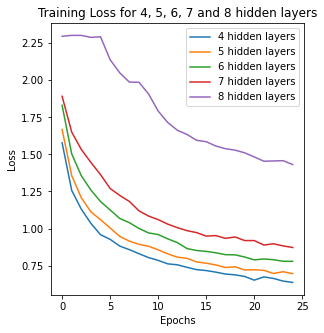

In [57]:
# Plotting the training loss and accuracy for 4, 5, 6, 7 and 8 hidden fully connected layers
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_4_tanh, label = "4 hidden layers")
plt.plot(train_loss_5_tanh, label = "5 hidden layers")
plt.plot(train_loss_6_tanh, label = "6 hidden layers")
plt.plot(train_loss_7_tanh, label = "7 hidden layers")
plt.plot(train_loss_8_tanh, label = "8 hidden layers")
plt.title("Training Loss for 4, 5, 6, 7 and 8 hidden layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Therefore, at 8 fully connected layers, we will encounter the vanishing gradient problem in case of tanh activation function because curve of tanh becomes almost flat after 8 layers and therefore we infer that difference between the losses of different epochs is less and hence the gradient is vanishing.

### Methods to overcome the above problem.

Note: We are using ReLU activation function here as it is a non-saturating function which means that it doesn't saturate to 0 or 1 and even with increasing number of layers, it doesn't lead to vanishing gradient problem.

In [58]:
model_8_fc_layers_relu = CNN(nn.ReLU(), 8, [512, 384, 256, 128, 64, 32, 20, 16], 10).to(device)
optimizer_8_fc_layers_relu = torch.optim.Adam(model_8_fc_layers_relu.parameters(), lr = 0.001)

# Training for ReLu with 8 hidden layers
train_loss_8_relu = []
train_accuracy_8_relu = []
train_loss_8_relu, train_accuracy_8_relu =  train_model(model = model_8_fc_layers_relu, optimizer = optimizer_8_fc_layers_relu, epochs = 25, train_loss = train_loss_8_relu, train_accuracy = train_accuracy_8_relu)
print("Training Complete for 8 hidden layers.")

Epoch: 1 Training Loss:  1.8338587415187866 	 Training Accuracy:  0.27798
Epoch: 2 Training Loss:  1.3831072228643901 	 Training Accuracy:  0.49184
Epoch: 3 Training Loss:  1.1352049062014236 	 Training Accuracy:  0.59724
Epoch: 4 Training Loss:  0.9895424614172152 	 Training Accuracy:  0.65602
Epoch: 5 Training Loss:  0.8913189994404688 	 Training Accuracy:  0.69686
Epoch: 6 Training Loss:  0.801126623397593 	 Training Accuracy:  0.72768
Epoch: 7 Training Loss:  0.7270015632100117 	 Training Accuracy:  0.75304
Epoch: 8 Training Loss:  0.6715558897656249 	 Training Accuracy:  0.7709
Epoch: 9 Training Loss:  0.6243040811680162 	 Training Accuracy:  0.7874
Epoch: 10 Training Loss:  0.5719188764272138 	 Training Accuracy:  0.80584
Epoch: 11 Training Loss:  0.5275332859105162 	 Training Accuracy:  0.82164
Epoch: 12 Training Loss:  0.49236766106027474 	 Training Accuracy:  0.83196
Epoch: 13 Training Loss:  0.4555536467400963 	 Training Accuracy:  0.84424
Epoch: 14 Training Loss:  0.43186950

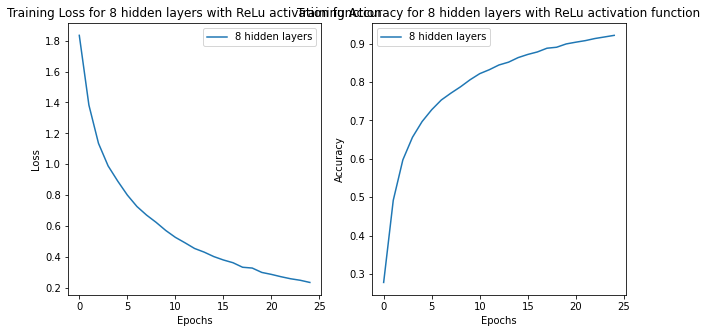

In [59]:
# Plotting the training loss and accuracy for 8 hidden fully connected layers with ReLu activation function
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_8_relu, label = "8 hidden layers")
plt.title("Training Loss for 8 hidden layers with ReLu activation function")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_8_relu, label = "8 hidden layers")
plt.title("Training Accuracy for 8 hidden layers with ReLu activation function")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Comparison between the 8 layer network with ReLU activation function, 8 layer network with tanh activation function and 5 hidden layer network with sigmoid activation function.

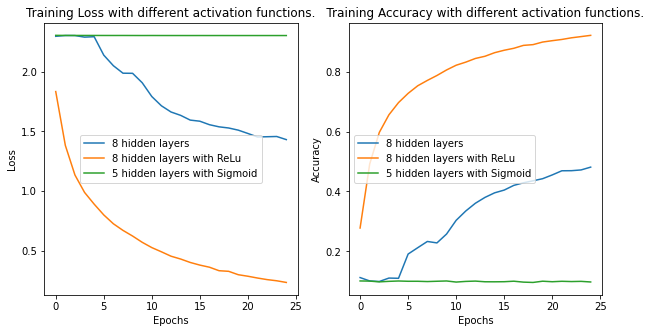

In [60]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_8_tanh, label = "8 hidden layers")
plt.plot(train_loss_8_relu, label = "8 hidden layers with ReLu")
plt.plot(train_loss_5, label = "5 hidden layers with Sigmoid")
plt.title("Training Loss with different activation functions.")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2, )
plt.plot(train_accuracy_8_tanh, label = "8 hidden layers")
plt.plot(train_accuracy_8_relu, label = "8 hidden layers with ReLu")
plt.plot(train_accuracy_5, label = "5 hidden layers with Sigmoid")
plt.title("     Training Accuracy with different activation functions.")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Therefore, we can conclude that the 8 layer network with ReLU activation function performs better than the 8 layer network with tanh activation function and the 5 hidden layer network with sigmoid activation function and hence vanishing gradient problem is overcome by using ReLU activation function.

## Question 2

In [61]:
# Loading the Gurmukhi dataset from the directory
train_loader_gur = torch.utils.data.DataLoader(
    datasets.ImageFolder('data/GurNum/train', transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)

test_loader_gur = torch.utils.data.DataLoader(
    datasets.ImageFolder('data/GurNum/val', transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)

In [62]:
X_train_gur = []
y_train_gur = []
X_test_gur = []
y_test_gur = []

for data, target in train_loader_gur:
    X_train_gur.append(data)
    y_train_gur.append(target)

for data, target in test_loader_gur:
    X_test_gur.append(data)
    y_test_gur.append(target)

X_train_gur = torch.cat(X_train_gur)
y_train_gur = torch.cat(y_train_gur)
X_test_gur = torch.cat(X_test_gur)
y_test_gur = torch.cat(y_test_gur)

In [63]:
print("X_train_gur shape: ", X_train_gur.shape)
print("y_train_gur shape: ", y_train_gur.shape)
print("X_test_gur shape: ", X_test_gur.shape)
print("y_test_gur shape: ", y_test_gur.shape)

X_train_gur shape:  torch.Size([1000, 3, 32, 32])
y_train_gur shape:  torch.Size([1000])
X_test_gur shape:  torch.Size([178, 3, 32, 32])
y_test_gur shape:  torch.Size([178])


In [64]:
classes_gur = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

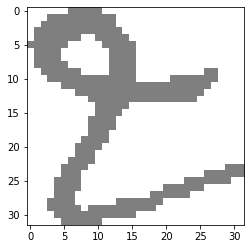

8


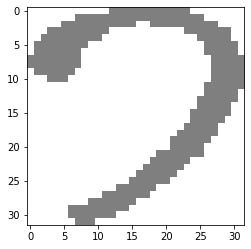

7


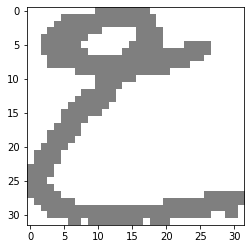

8


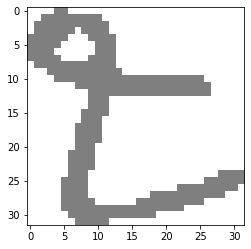

8


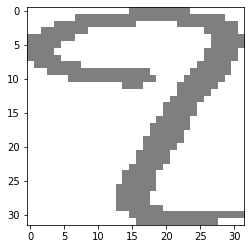

1


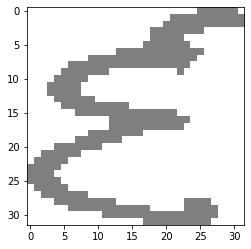

6


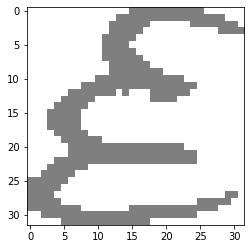

6


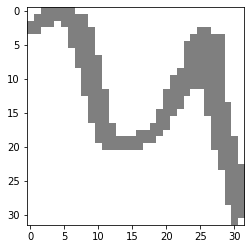

5


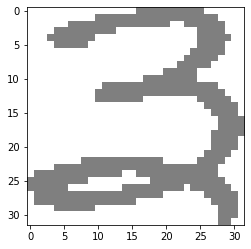

3


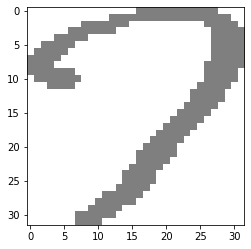

7


In [65]:
def imshow_gur(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show 10 images with labels from the training set
for i in range(10):
    imshow_gur(X_train_gur[i])
    print(classes_gur[y_train_gur[i]])

In [66]:
def create_dataloader_gur(X_train_gur, y_train_gur, X_test_gur, y_test_gur):
    print(X_train_gur.shape, y_train_gur.shape, X_test_gur.shape, y_test_gur.shape)

    trainset = torch.utils.data.TensorDataset(X_train_gur, y_train_gur)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test_gur, y_test_gur)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

    return trainloader, testloader

trainloader_gur, testloader_gur = create_dataloader_gur(X_train_gur, y_train_gur, X_test_gur, y_test_gur)

torch.Size([1000, 3, 32, 32]) torch.Size([1000]) torch.Size([178, 3, 32, 32]) torch.Size([178])


### Implementing a neural network on the Gurmukhi dataset and implement the following regularization techniques from scratch:
    L-1 regularization
    L-2 regularization

In [67]:
class CNN_Gurmukhi(nn.Module):
    def __init__(self, activation_function, l1_factor, l2_factor, num_classes, dropout_prob):
        super(CNN_Gurmukhi, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*4*4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.activation_function = activation_function
        self.l1_factor = l1_factor
        self.l2_factor = l2_factor
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(self.dropout_prob)

    def l1_regularization(self):
        return self.l1_factor * torch.sum (torch.abs(self.fc1.weight)) + self.l1_factor * torch.sum (torch.abs(self.fc2.weight)) + self.l1_factor * torch.sum (torch.abs(self.fc3.weight))

    def l2_regularization(self):
        return self.l2_factor * torch.sum (self.fc1.weight**2) + self.l2_factor * torch.sum (self.fc2.weight**2) + self.l2_factor * torch.sum (self.fc3.weight**2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = nn.Softmax(dim=1)(x)
        return x

#### L1 Regularization

In [68]:
model_gur_l1 = CNN_Gurmukhi(activation_function = nn.ReLU(), l1_factor = 0.0001, l2_factor = 0, num_classes = 10,dropout_prob = 0).to(device)
model_gur_l1

CNN_Gurmukhi(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (activation_function): ReLU()
  (dropout): Dropout(p=0, inplace=False)
)

In [69]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gur_l1.parameters(), lr=0.001)

In [70]:
# Training the model and applying L1 regularization
def train_model_gur_l1(model, optimizer, epochs, train_loss, train_accuracy):
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(trainloader_gur):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels) + model.l1_regularization()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss.append(loss.item())
        train_accuracy.append(correct / total)
        print ('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%'
            .format(epoch+1, epochs, loss.item(), (correct / total) * 100))

    return train_loss, train_accuracy

In [71]:
train_loss_gur_l1 = []
train_accuracy_gur_l1 = []
train_loss_gur_l1, train_accuracy_gur_l1 = train_model_gur_l1(model_gur_l1, optimizer, 50, train_loss_gur_l1, train_accuracy_gur_l1)
print("Training complete with L1 regularization")

Epoch [1/50], Training Loss: 2.3960, Training Accuracy: 14.00%
Epoch [2/50], Training Loss: 1.8933, Training Accuracy: 45.20%
Epoch [3/50], Training Loss: 1.8488, Training Accuracy: 74.90%
Epoch [4/50], Training Loss: 2.0047, Training Accuracy: 77.50%
Epoch [5/50], Training Loss: 1.6375, Training Accuracy: 81.50%
Epoch [6/50], Training Loss: 1.8343, Training Accuracy: 85.30%
Epoch [7/50], Training Loss: 1.6329, Training Accuracy: 88.70%
Epoch [8/50], Training Loss: 1.5922, Training Accuracy: 94.00%
Epoch [9/50], Training Loss: 1.5731, Training Accuracy: 96.50%
Epoch [10/50], Training Loss: 1.5611, Training Accuracy: 97.80%
Epoch [11/50], Training Loss: 1.5597, Training Accuracy: 97.40%
Epoch [12/50], Training Loss: 1.7008, Training Accuracy: 95.00%
Epoch [13/50], Training Loss: 1.5773, Training Accuracy: 97.50%
Epoch [14/50], Training Loss: 1.5509, Training Accuracy: 98.60%
Epoch [15/50], Training Loss: 1.5703, Training Accuracy: 97.10%
Epoch [16/50], Training Loss: 1.5493, Training Ac

In [72]:
# Testing the model and applying L1 regularization
def test_model_gur_l1(model, test_loss, test_accuracy):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader_gur:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) + model.l1_regularization()
            test_loss.append(loss.item())
            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        test_accuracy.append(correct / total)
        print('Test Loss of the model on the test images: {}'.format(loss.item()))
        print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

    return test_loss, test_accuracy

test_loss_gur_l1 = []
test_accuracy_gur_l1 = []
test_loss_gur_l1, test_accuracy_gur_l1 = test_model_gur_l1(model_gur_l1, test_loss_gur_l1, test_accuracy_gur_l1)
print("Testing complete with L1 regularization.")

Test Loss of the model on the test images: 1.4963674545288086
Test Accuracy of the model on the test images: 97.19101123595506 %
Testing complete with L1 regularization.


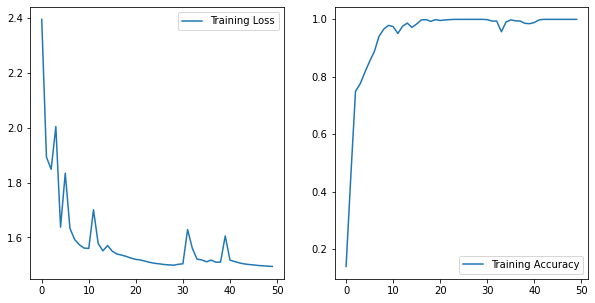

In [73]:
# Plotting the loss and accuracy curve for training data with L1 regularization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_gur_l1, label='Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_gur_l1, label='Training Accuracy')
plt.legend()
plt.show()

#### L2 Regularization

In [74]:
model_gur_l2 = CNN_Gurmukhi(activation_function = nn.ReLU(), l1_factor = 0, l2_factor = 0.0001, num_classes = 10,dropout_prob = 0).to(device)
optimizer = torch.optim.Adam(model_gur_l2.parameters(), lr=0.001)

In [75]:
# Training the model and applying L2 regularization
def train_model_gur_l2(model, optimizer, epochs, train_loss, train_accuracy):
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(trainloader_gur):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels) + model.l2_regularization()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss.append(loss.item())
        train_accuracy.append(correct / total)
        print ('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%'
            .format(epoch+1, epochs, loss.item(), (correct / total) * 100))

    return train_loss, train_accuracy

In [76]:
train_loss_gur_l2 = []
train_accuracy_gur_l2 = []
train_loss_gur_l2, train_accuracy_gur_l2 = train_model_gur_l2(model_gur_l2, optimizer, 50, train_loss_gur_l2, train_accuracy_gur_l2)
print("Training complete with L2 regularization")

Epoch [1/50], Training Loss: 1.7776, Training Accuracy: 26.80%
Epoch [2/50], Training Loss: 1.5962, Training Accuracy: 80.40%
Epoch [3/50], Training Loss: 1.7415, Training Accuracy: 85.80%
Epoch [4/50], Training Loss: 1.7221, Training Accuracy: 86.30%
Epoch [5/50], Training Loss: 1.5985, Training Accuracy: 87.90%
Epoch [6/50], Training Loss: 1.5981, Training Accuracy: 88.20%
Epoch [7/50], Training Loss: 1.4888, Training Accuracy: 88.30%
Epoch [8/50], Training Loss: 1.4731, Training Accuracy: 89.10%
Epoch [9/50], Training Loss: 1.5980, Training Accuracy: 89.70%
Epoch [10/50], Training Loss: 1.4726, Training Accuracy: 89.80%
Epoch [11/50], Training Loss: 1.4724, Training Accuracy: 89.50%
Epoch [12/50], Training Loss: 1.5981, Training Accuracy: 89.60%
Epoch [13/50], Training Loss: 1.4719, Training Accuracy: 89.80%
Epoch [14/50], Training Loss: 1.8463, Training Accuracy: 90.00%
Epoch [15/50], Training Loss: 1.5957, Training Accuracy: 90.00%
Epoch [16/50], Training Loss: 1.5953, Training Ac

In [77]:
# Testing the model and applying L2 regularization
def test_model_gur_l2(model, test_loss, test_accuracy):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader_gur:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) + model.l2_regularization()
            test_loss.append(loss.item())
            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        test_accuracy.append(correct / total)
        print('Test Loss of the model on the test images: {}'.format(loss.item()))
        print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

    return test_loss, test_accuracy

test_loss_gur_l2 = []
test_accuracy_gur_l2 = []
test_loss_gur_l2, test_accuracy_gur_l2 = test_model_gur_l2(model_gur_l2, test_loss_gur_l2, test_accuracy_gur_l2)
print("Testing complete with L2 regularization.")

Test Loss of the model on the test images: 1.4697009325027466
Test Accuracy of the model on the test images: 97.19101123595506 %
Testing complete with L2 regularization.


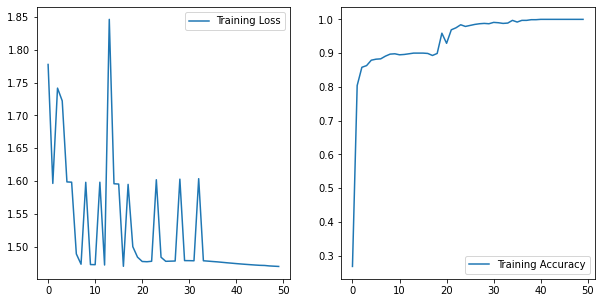

In [78]:
# Plotting the loss and accuracy curve for training data with L2 regularization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_gur_l2, label='Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_gur_l2, label='Training Accuracy')
plt.legend()
plt.show()

### Implementing the Dropout techniques using Pytorch:

In [79]:
model_gur_dropout = CNN_Gurmukhi(activation_function = nn.ReLU(), l1_factor = 0, l2_factor = 0, num_classes = 10,dropout_prob = 0.2).to(device)
optimizer = torch.optim.Adam(model_gur_dropout.parameters(), lr=0.001)

In [80]:
# Training the model and applying dropout
def train_model_gur_dropout(model, optimizer, epochs, train_loss, train_accuracy):
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(trainloader_gur):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss.append(loss.item())
        train_accuracy.append(correct / total)
        print ('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%'
            .format(epoch+1, epochs, loss.item(), (correct / total) * 100))

    return train_loss, train_accuracy

train_loss_gur_dropout = []
train_accuracy_gur_dropout = []
train_loss_gur_dropout, train_accuracy_gur_dropout = train_model_gur_dropout(model_gur_dropout, optimizer, 50, train_loss_gur_dropout, train_accuracy_gur_dropout)
print("Training complete with dropout")

Epoch [1/50], Training Loss: 1.9228, Training Accuracy: 29.20%
Epoch [2/50], Training Loss: 1.5880, Training Accuracy: 81.90%
Epoch [3/50], Training Loss: 1.4618, Training Accuracy: 85.60%
Epoch [4/50], Training Loss: 1.5963, Training Accuracy: 87.80%
Epoch [5/50], Training Loss: 1.4615, Training Accuracy: 93.60%
Epoch [6/50], Training Loss: 1.4623, Training Accuracy: 94.70%
Epoch [7/50], Training Loss: 1.4613, Training Accuracy: 97.20%
Epoch [8/50], Training Loss: 1.4612, Training Accuracy: 96.90%
Epoch [9/50], Training Loss: 1.4612, Training Accuracy: 97.60%
Epoch [10/50], Training Loss: 1.4612, Training Accuracy: 98.10%
Epoch [11/50], Training Loss: 1.4614, Training Accuracy: 96.50%
Epoch [12/50], Training Loss: 1.4612, Training Accuracy: 98.30%
Epoch [13/50], Training Loss: 1.4612, Training Accuracy: 98.60%
Epoch [14/50], Training Loss: 1.5861, Training Accuracy: 98.40%
Epoch [15/50], Training Loss: 1.4618, Training Accuracy: 98.20%
Epoch [16/50], Training Loss: 1.4612, Training Ac

In [81]:
# Testing the model and applying dropout
def test_model_gur_dropout(model, test_loss, test_accuracy):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader_gur:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())
            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        test_accuracy.append(correct / total)
        print('Test Loss of the model on the test images: {}'.format(loss.item()))
        print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

    return test_loss, test_accuracy

test_loss_gur_dropout = []
test_accuracy_gur_dropout = []
test_loss_gur_dropout, test_accuracy_gur_dropout = test_model_gur_dropout(model_gur_dropout, test_loss_gur_dropout, test_accuracy_gur_dropout)
print("Testing complete with dropout.")

Test Loss of the model on the test images: 1.4611506462097168
Test Accuracy of the model on the test images: 98.31460674157303 %
Testing complete with dropout.


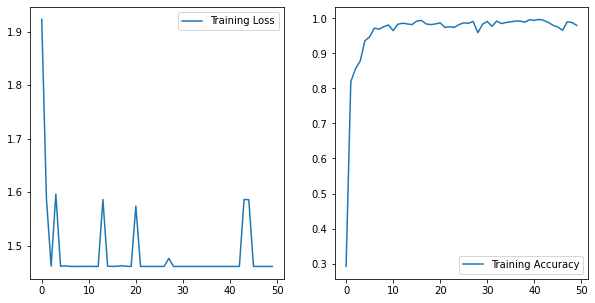

In [82]:
# Plotting the loss and accuracy curve for training data with dropout
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_gur_dropout, label='Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_gur_dropout, label='Training Accuracy')
plt.legend()
plt.show()

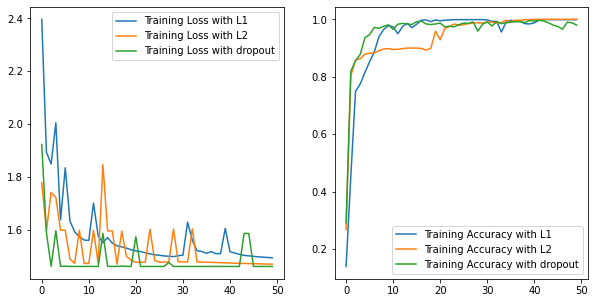

In [83]:
# Plotting the loss and accuracy curve for training data with L1, L2 regularization and dropout.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_gur_l1, label='Training Loss with L1')
plt.plot(train_loss_gur_l2, label='Training Loss with L2')
plt.plot(train_loss_gur_dropout, label='Training Loss with dropout')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_gur_l1, label='Training Accuracy with L1')
plt.plot(train_accuracy_gur_l2, label='Training Accuracy with L2')
plt.plot(train_accuracy_gur_dropout, label='Training Accuracy with dropout')
plt.legend()
plt.show()

In [84]:
model___ = CNN_Gurmukhi(activation_function = nn.ReLU(), l1_factor = 0.0001, l2_factor = 0.0001, num_classes = 10,dropout_prob = 0.2).to(device)
optimizer = torch.optim.Adam(model___.parameters(), lr=0.001)

In [85]:
def gradient_checking(model, criterion, optimizer, trainloader_gur, device):
    model.train()
    for images, labels in trainloader_gur:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        # Gradient checking
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(name)
                print(param.grad)
                print(param.grad.shape)

        break

gradient_checking(model___, criterion, optimizer, trainloader_gur, device)

conv1.weight
tensor([[[[-1.2892e-05, -3.5369e-05, -3.5232e-05],
          [-3.5847e-05,  0.0000e+00,  0.0000e+00],
          [-3.5465e-05,  1.0099e-06,  0.0000e+00]],

         [[-1.2892e-05, -3.5369e-05, -3.5232e-05],
          [-3.5847e-05,  0.0000e+00,  0.0000e+00],
          [-3.5465e-05,  1.0099e-06,  0.0000e+00]],

         [[-1.2892e-05, -3.5369e-05, -3.5232e-05],
          [-3.5847e-05,  0.0000e+00,  0.0000e+00],
          [-3.5465e-05,  1.0099e-06,  0.0000e+00]]],


        [[[ 5.7994e-06,  0.0000e+00,  0.0000e+00],
          [ 4.6801e-05,  4.8249e-05,  2.8404e-05],
          [ 0.0000e+00,  3.2248e-08,  7.2007e-06]],

         [[ 5.7994e-06,  0.0000e+00,  0.0000e+00],
          [ 4.6801e-05,  4.8249e-05,  2.8404e-05],
          [ 0.0000e+00,  3.2248e-08,  7.2007e-06]],

         [[ 5.7994e-06,  0.0000e+00,  0.0000e+00],
          [ 4.6801e-05,  4.8249e-05,  2.8404e-05],
          [ 0.0000e+00,  3.2248e-08,  7.2007e-06]]],


        [[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
  

---